In [1]:
import rebound
import reboundx
import numpy as np
from rebound import InterruptiblePool
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
sim = rebound.Simulation()
sim.integrator = "whfast"
sim.dt = 0.01
sim.add(m=1.)
    
e0 = 0.1
sim.add(m=1e-6,a=1.,e=e0, inc=0.)
sim.add(m=1e-6,a=2.,e=e0, inc=0.)
sim.move_to_com() # Moves to the center of momentum frame
    
rebx = reboundx.Extras(sim)
rebx.add_modify_orbits_direct()
    
tau = -1000.
tau_es = rebx.modify_orbits_direct.tau_e # nice shortcut so we don't have to keep typing the long name
tau_incs = rebx.modify_orbits_direct.tau_inc
tau_es[1] = tau  # this is for particles[1]

sim.step()

In [3]:
sim.step()

In [3]:
def getstr(dt):
    return "{:.0e}".format(dt)

def simulation(par):
    tmax, run, e0, integrator, dt, tau = par
    sim = rebound.Simulation()
    sim.integrator = integrator
    sim.dt = dt
    sim.add(m=1.)
    
    np.random.seed(run)
    e0 = e0 + 1.e-14*np.random.rand() 
    sim.add(m=1e-3,a=1.,e=e0, inc=0.)
    #sim.add(m=1e-3,a=3.,e=e0, inc=0.)
    sim.move_to_com() # Moves to the center of momentum frame
    
    rebx = reboundx.Extras(sim)
    rebx.add_modify_orbits_direct()
    
    tau_es = rebx.modify_orbits_direct.tau_e # nice shortcut so we don't have to keep typing the long name
    tau_incs = rebx.modify_orbits_direct.tau_inc
    tau_es[1] = tau  # this is for particles[1]
    #tau_es[2] = -tmax      # this is for particles[2]
    tau_incs[1] = -tmax/10.  
    #tau_incs[2] = -tmax     
    
    Nout = 1e4
    e1,e2,inc1,inc2,ts = np.zeros(Nout), np.zeros(Nout), np.zeros(Nout), np.zeros(Nout), np.zeros(Nout)
    times = np.logspace(np.log10(dt),np.log10(tmax),Nout)
    for i,time in enumerate(times):
        sim.integrate(time, exact_finish_time=0)
        ts[i] = sim.t
        orbits = sim.calculate_orbits() # returns an array of orbits, where the 0 element is the first *PLANET*
        e1[i] = orbits[0].e
        #e2[i] = orbits[1].e
        inc1[i] = orbits[0].inc
        #inc2[i] = orbits[1].inc
        
    e1pred = [e0*np.e**(t/tau_es[1]) for t in ts]
    #e2pred = [e0*np.e**(t/tau_es[2]) for t in times]

    err = np.array([np.fabs(e1[i] - e1pred[i])/e1pred[i] for i in range(len(e1))])
    return [times, err, e1, getstr(dt), tau]

In [4]:
def plot(integrator, ax, plterr=False):
    Nruns = 1
    tmax = 1.e3
    e0 = 0.1
    dts = np.logspace(-5,-3,3)
    integrators = ['whfast', 'ias15']
    cs = ['red', 'green', 'blue']
    dtstrs = [getstr(dt) for dt in dts]
    colors = dict(zip(dtstrs,cs))
    tau=-1000000.
    params = [(tmax, run, e0, integrator, dt,tau) for run in range(Nruns) for dt in dts]
    pool = InterruptiblePool()
    res = pool.map(simulation, params)

    ax.set_yscale('log')
    #ax.set_ylim([0.001,1])
    for times, err, e1, dtstr, tau in res:
        if plterr==True:
            ax.plot(times,err, color=colors[dtstr], alpha=0.2)
            ax.set_xscale('log')
            ax.set_ylabel("Rel Err", fontsize=24)
            ax.set_xlabel("Time", fontsize=24)
            ax.set_xlim([min(dts), tmax])
            #ax.set_ylim([1.e-8,0.1])
        else:
            ax.plot(times,e1, color=colors[dtstr], label='dt='+dtstr, alpha=0.8)
            ax.set_ylabel("e", fontsize=24)
            ax.set_title(integrator, fontsize=24)
    labels = [plt.Line2D((0,1),(0,0), color=c, linestyle='-', linewidth=2) for c in cs]
    ax.legend(labels, ['dt='+dtstr for dtstr in dtstrs])

In [6]:
def plotrise(integrator, ax, plterr=False):
    Nruns = 1
    tmax = 3.e1
    e0 = 0.1
    dts = np.logspace(-3,-1,3)
    integrators = ['whfast', 'ias15']
    cs = ['red', 'green', 'blue']
    dtstrs = [getstr(dt) for dt in dts]
    colors = dict(zip(dtstrs,cs))
    tau=-1.
    params = [(tmax, run, e0, integrator, dt,tau) for run in range(Nruns) for dt in dts]
    pool = InterruptiblePool()
    res = pool.map(simulation, params)

    ax.set_yscale('log')
    #ax.set_ylim([0.001,1])
    for times, err, e1, dtstr, tau in res:
        if plterr==True:
            ax.plot([-t/tau for t in times],err, color=colors[dtstr], alpha=0.2)
            #ax.set_xscale('log')
            ax.set_ylabel("Rel Err", fontsize=24)
            ax.set_xlabel("Time", fontsize=24)
            #ax.set_xlim([0.001, tmax])
            #ax.set_ylim([1.e-8,0.1])
        else:
            ax.plot(times,e1, color=colors[dtstr], label='dt='+dtstr, alpha=0.8)
            ax.set_ylabel("e", fontsize=24)
            ax.set_title(integrator, fontsize=24)
    labels = [plt.Line2D((0,1),(0,0), color=c, linestyle='-', linewidth=2) for c in cs]
    ax.legend(labels, ['dt='+dtstr for dtstr in dtstrs])

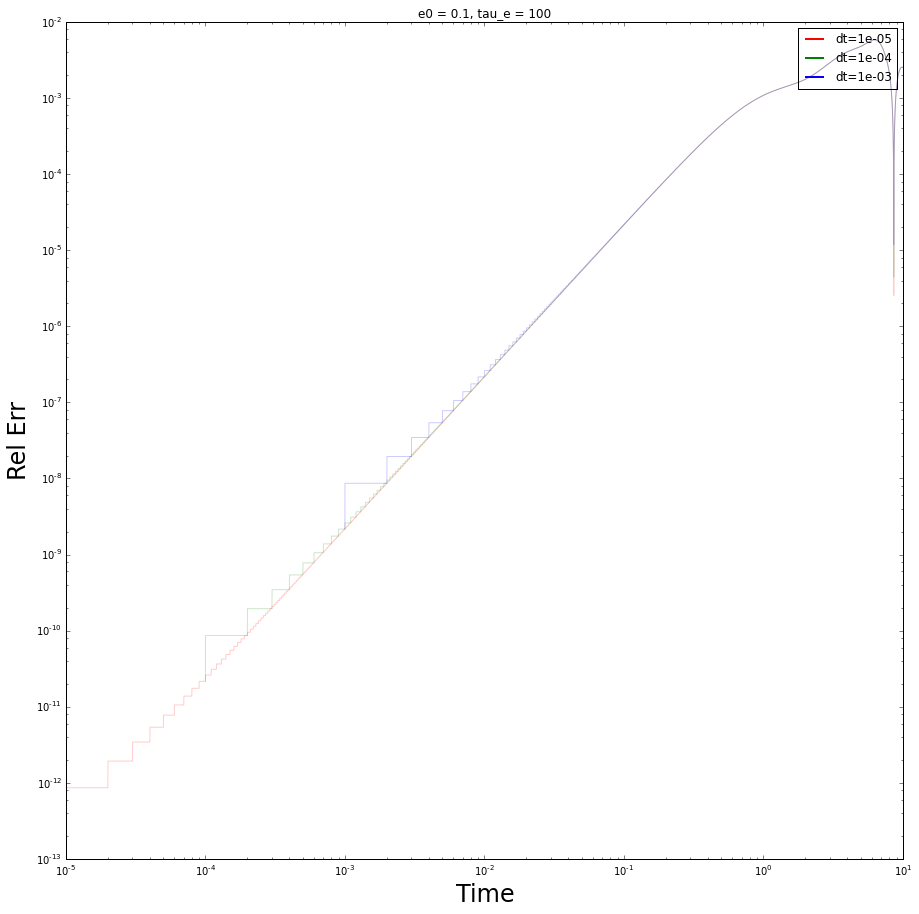

In [4]:
fig, ax = plt.subplots(figsize=(15,15))
plot("whfast", ax, plterr=True)
ax.set_title("e0 = 0.1, tau_e = 100")

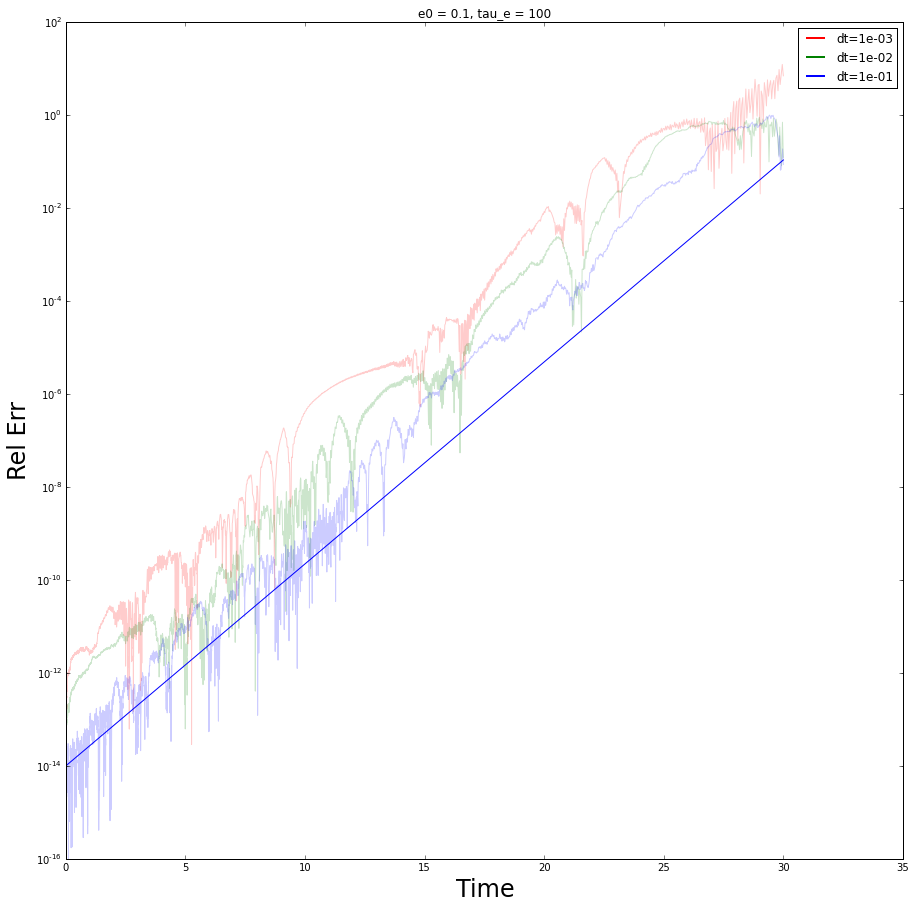

In [15]:
fig, ax = plt.subplots(figsize=(15,15))
plotrise("whfast", ax, plterr=True)
ax.set_title("e0 = 0.1, tau_e = 100")
ts = np.linspace(0,30,100)
prederrs = [10**(-14 + t/np.log(10.)) for t in ts]
ax.plot(ts,prederrs)

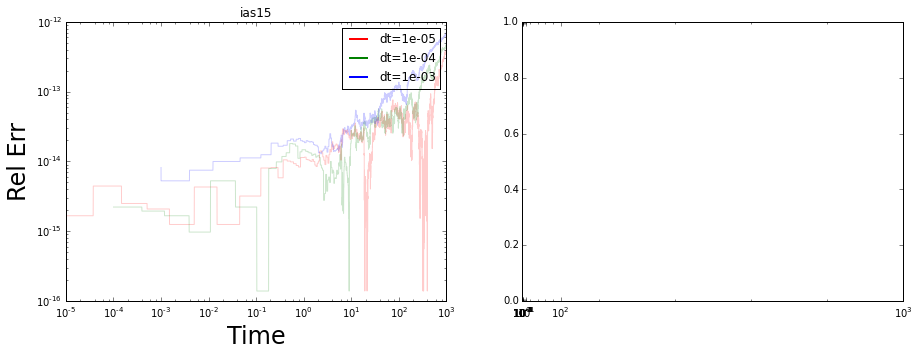

In [5]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2 , figsize=(15,5), sharex=True)
plot("ias15", ax1, plterr=True)
#plot("whfast", ax2, plterr=True)
ax1.set_title("ias15")
#ax2.set_title("whfast")

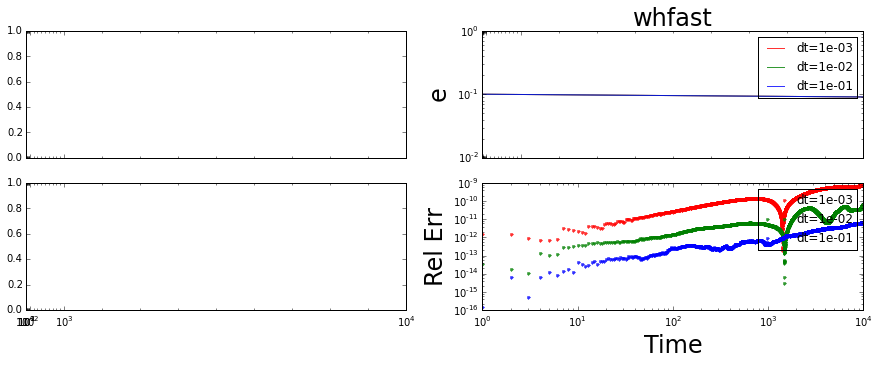

In [4]:
fig, axarr = plt.subplots(nrows=2, ncols=2 , figsize=(15,5), sharex=True)
#plot("ias15", axarr[0,0])
plot("whfast", axarr[0,1])
#plot("ias15", axarr[1,0], plterr=True)
plot("whfast", axarr[1,1], plterr=True)

In [12]:
def getstr(dt):
    return "{:.0e}".format(dt)

def simNOREBX(par):
    tmax, run, e0, integrator, dt, tau = par
    sim = rebound.Simulation()
    sim.integrator = integrator
    sim.dt = dt
    sim.add(m=1.)
    
    np.random.seed(run)
    e0 = e0 + 1.e-14*np.random.rand() 
    sim.add(m=1e-3,a=1.,e=e0, inc=0.)
    sim.add(m=1e-3,a=3.,e=e0, inc=0.)
    sim.move_to_com() # Moves to the center of momentum frame  
    
    Nout = 1e4
    e1,e2,inc1,inc2,ts = np.zeros(Nout), np.zeros(Nout), np.zeros(Nout), np.zeros(Nout), np.zeros(Nout)
    times = np.logspace(np.log10(dt),np.log10(tmax),Nout)
    for i,time in enumerate(times):
        sim.integrate(time, exact_finish_time=0)
        ts[i] = sim.t
        orbits = sim.calculate_orbits() # returns an array of orbits, where the 0 element is the first *PLANET*
        e1[i] = orbits[0].e
        #e2[i] = orbits[1].e
        inc1[i] = orbits[0].inc
        #inc2[i] = orbits[1].inc

    err = np.array([np.fabs(e1[i] - e0)/e0 for i in range(len(e1))])
    return [times, err, e1, getstr(dt), tau]

def plotNOREBX(integrator, ax, plterr=False):
    Nruns = 4
    tmax = 3.
    e0 = 0.1
    dts = np.logspace(-5,-3,3)
    integrators = ['whfast', 'ias15']
    cs = ['red', 'green', 'blue']
    dtstrs = [getstr(dt) for dt in dts]
    colors = dict(zip(dtstrs,cs))
    tau=-100.
    params = [(tmax, run, e0, integrator, dt,tau) for run in range(Nruns) for dt in dts]
    pool = InterruptiblePool()
    res = pool.map(simNOREBX, params)

    ax.set_yscale('log')
    #ax.set_ylim([0.001,1])
    for times, err, e1, dtstr, tau in res:
        if plterr==True:
            ax.plot(times,err, color=colors[dtstr], alpha=0.2)
            ax.set_xscale('log')
            ax.set_ylabel("Rel Err", fontsize=24)
            ax.set_xlabel("Time", fontsize=24)
            ax.set_xlim([min(dts), tmax])
            #ax.set_ylim([1.e-8,0.1])
        else:
            ax.plot(times,e1, color=colors[dtstr], label='dt='+dtstr, alpha=0.8)
            ax.set_ylabel("e", fontsize=24)
            ax.set_title(integrator, fontsize=24)
    labels = [plt.Line2D((0,1),(0,0), color=c, linestyle='-', linewidth=2) for c in cs]
    ax.legend(labels, ['dt='+dtstr for dtstr in dtstrs])

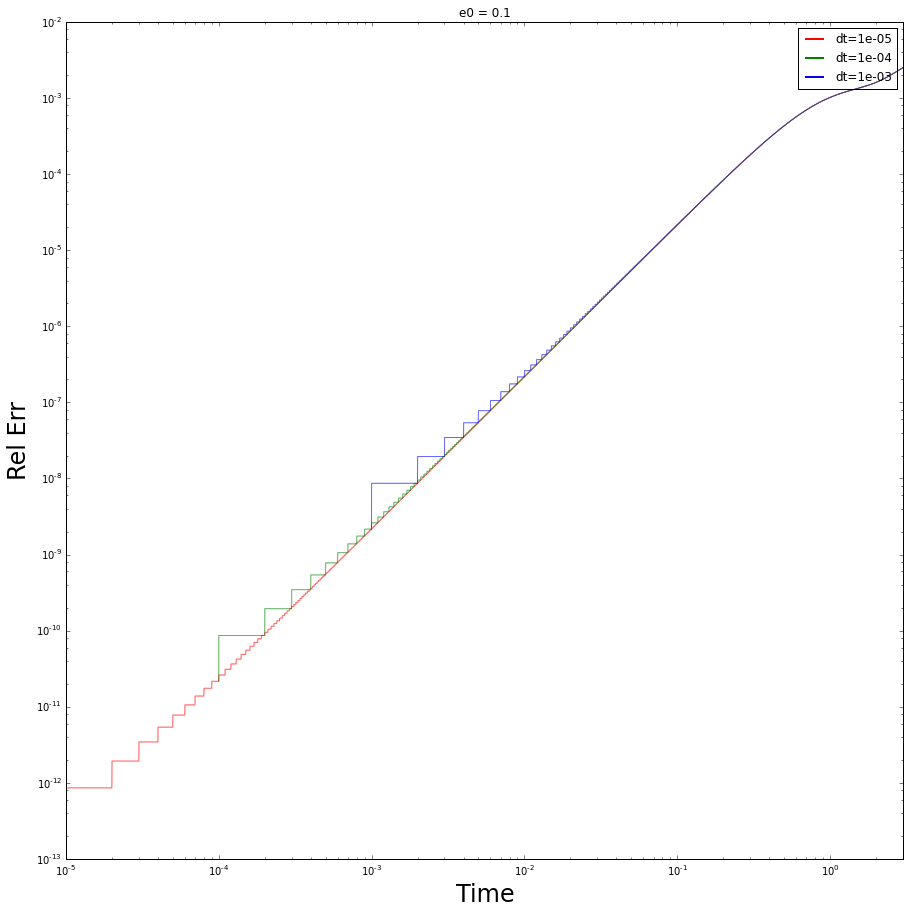

In [13]:
fig, ax = plt.subplots(figsize=(15,15))
plotNOREBX("whfast", ax, plterr=True)
ax.set_title("e0 = 0.1")